install the following libraries if not installed in devce 

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-07-27 03:36:52.041151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 03:36:52.041200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 03:36:52.042590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-27 03:36:52.051355: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-27 03:36:53.084317: W tensorflow/compiler/tf2

# Set the base path to the dataset

In [2]:
# Set the base path to the dataset
BASE_PATH = "/home/ubuntu/BSC/Breast_Cancer_Segmentation/Dataset_BUSI_with_GT" # change the path
unique_classes = []

# Check if the path exists and list unique classes
if os.path.exists(BASE_PATH):
    for path in os.listdir(BASE_PATH):
        unique_classes.append(path)
    print("Unique classes found:", unique_classes)
else:
    raise FileNotFoundError(f"The specified path does not exist: {BASE_PATH}")

# Sort classes to ensure consistent order
class_index = sorted(unique_classes)
print("Class index sorted:", class_index)

Unique classes found: ['normal', 'malignant', 'benign']
Class index sorted: ['benign', 'malignant', 'normal']


# Function to load the dataset

In [3]:
# Function to load the dataset
def load_dataset(base_path, class_index, image_size):
    images = []
    masks = []
    filenames = []
    for category in class_index:
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            raise FileNotFoundError(f"The category path does not exist: {category_path}")
        
        for file in os.listdir(category_path):
            if 'mask' not in file:  # Exclude mask files for image loading
                image_path = os.path.join(category_path, file)
                mask_path = os.path.join(category_path, file.split('.')[0] + '_mask.png')
                
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                if image is not None and mask is not None:
                    if image.shape == mask.shape:
                        image_resized = cv2.resize(image, (image_size, image_size))
                        mask_resized = cv2.resize(mask, (image_size, image_size))
                        images.append(image_resized)
                        masks.append(mask_resized)
                        filenames.append(file)
                    else:
                        print(f"Warning: Image and mask shape mismatch for {file}")
                else:
                    print(f"Warning: Could not load image or mask for {file}")

    return np.array(images), np.array(masks), filenames


In [4]:
# Parameters
image_size = 256 # 
# Load and preprocess the dataset
# images, masks = load_dataset(BASE_PATH, class_index, image_size)
images, masks, filenames = load_dataset(BASE_PATH, class_index, image_size)

In [5]:
# Normalize images and add channel dimension
images = np.expand_dims(images, axis=-1) / 255.0
masks = np.expand_dims(masks, axis=-1) / 255.0

In [6]:
# Split the dataset into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [8]:
# Data augmentation
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     rotation_range=90,
                     zoom_range=0.2,
                     shear_range=0.2,
                     fill_mode='reflect')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)



In [9]:
# Fit the generators to the data
seed = 42
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

In [10]:
# Function to visualize images and their masks
def visualize_samples(images, masks, filenames, num_samples=5):
    indices = np.random.choice(len(images), num_samples, replace=False)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    for i, idx in enumerate(indices):
        ax_image, ax_mask = axes[i]
        ax_image.imshow(images[idx], cmap='gray')
        ax_image.set_title(f"Image: {filenames[idx]}")
        ax_image.axis('off')
        
        ax_mask.imshow(masks[idx], cmap='gray')
        ax_mask.set_title(f"Mask: {filenames[idx].split('.')[0]}_mask.png")
        ax_mask.axis('off')
    
    plt.tight_layout()
    plt.show()

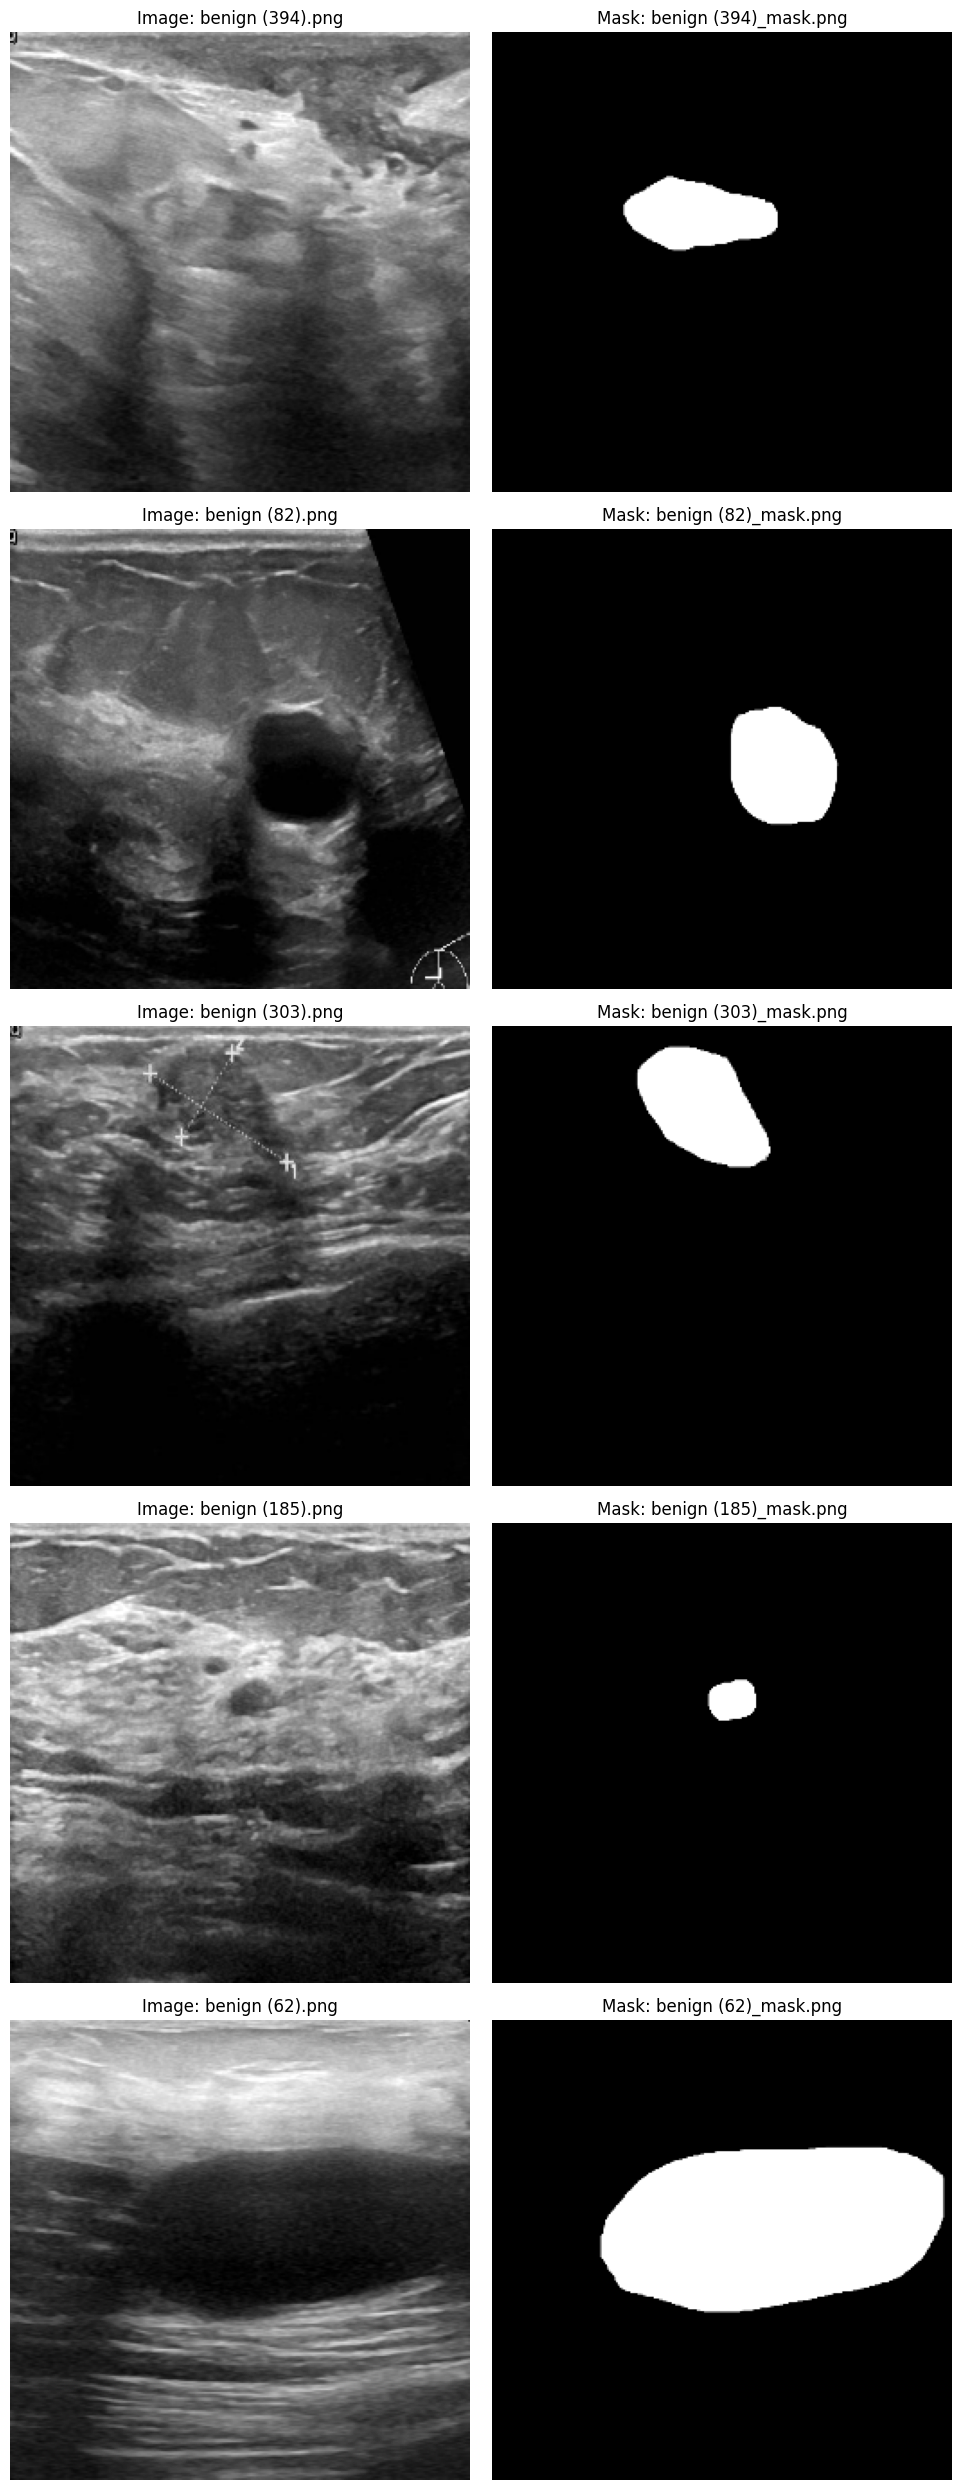

In [11]:
# Visualize some samples
visualize_samples(images, masks, filenames)

In [ ]:
# # Function to preprocess the images
# def preprocess_images(images, masks):
#     images = images.astype('float32') / 255.0
#     masks = masks.astype('float32') / 255.0
#     masks = np.expand_dims(masks, axis=-1)
#     return np.expand_dims(images, axis=-1), masks

In [ ]:
# images, masks = preprocess_images(images, masks)

# U-Net Model Architecture

In [12]:
# Define the U-Net model
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.25)(pool2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.25)(pool3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)

    up5 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop4))
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    conv8 = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs, conv8)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
# # Split the dataset into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [13]:
# Create the model
model = unet_model()

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('model_checkpoint.h5', save_best_only=True)
    ]

2024-07-27 03:39:29.888308: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-27 03:39:30.600952: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-27 03:39:30.601223: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Compile and train the U-Net model

In [14]:
# # Compile and train the U-Net model
# input_size = (image_size, image_size, 1)
# model = unet_model(input_size)
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_val, y_val))

In [15]:
# Train the model with data augmentation
batch_size = 16
train_generator = zip(image_datagen.flow(X_train, batch_size=batch_size, seed=seed),
                      mask_datagen.flow(y_train, batch_size=batch_size, seed=seed))

history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/50


2024-07-27 03:40:12.921231: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-07-27 03:40:13.403139: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-27 03:40:13.960797: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-27 03:40:15.345617: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-27 03:40:22.073447: I external/local_xla/xla/service/service.cc:168] XLA service 0x7a5639a32d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-27 03:40:22.073485: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Comp

39/39 [==============================] - ETA: 0s - loss: 0.3725 - accuracy: 0.9045

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 56s 826ms/step - loss: 0.3725 - accuracy: 0.9045 - val_loss: 0.2673 - val_accuracy: 0.9272
Epoch 2/50
Epoch 2/50
39/39 [==============================] - 11s 293ms/step - loss: 0.2841 - accuracy: 0.9138 - val_loss: 0.2555 - val_accuracy: 0.9272
Epoch 3/50
39/39 [==============================] - 11s 293ms/step - loss: 0.2797 - accuracy: 0.9134 - val_loss: 0.2507 - val_accuracy: 0.9272
Epoch 4/50
39/39 [==============================] - 11s 293ms/step - loss: 0.2784 - accuracy: 0.9147 - val_loss: 0.2496 - val_accuracy: 0.9272
Epoch 5/50
39/39 [==============================] - 11s 292ms/step - loss: 0.2729 - accuracy: 0.9152 - val_loss: 0.2482 - val_accuracy: 0.9272
Epoch 6/50
39/39 [==============================] - 11s 293ms/step - loss: 0.2725 - accuracy: 0.9139 - val_loss: 0.2341 - val_accuracy: 0.9272
Epoch 7/50
39/39 [==============================] - 11s 293ms/step - loss: 0.2599 - accuracy: 0.9144 - val_loss: 0.2176 - val_accuracy: 0.9272

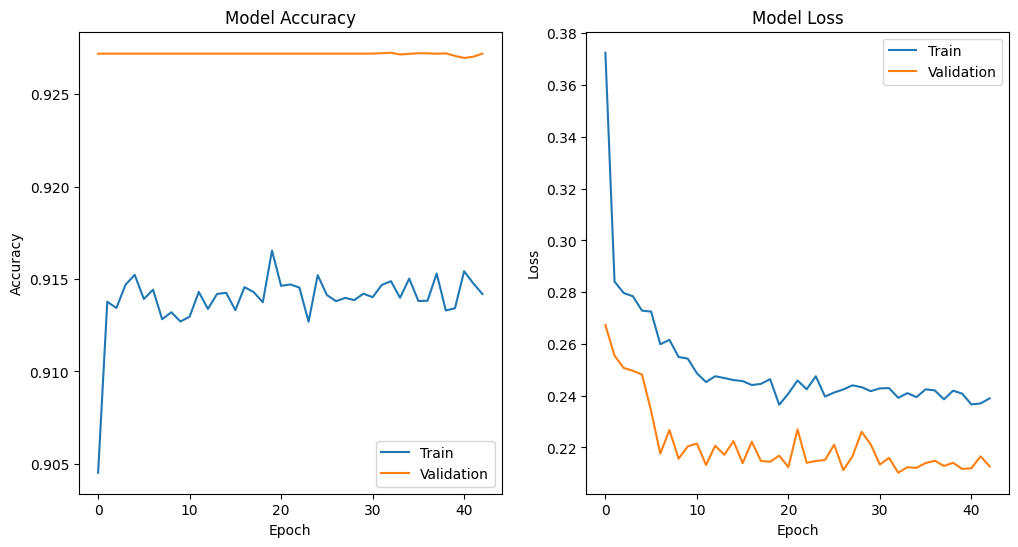

In [16]:
# Visualize training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.show()

# Plot training history
plot_training_history(history)

In [17]:
# Define a function to visualize predictions
def visualize_predictions(model, X_val, y_val, num_samples=5):
    indices = np.random.choice(len(X_val), num_samples, replace=False)
    for i in indices:
        img = X_val[i]
        true_mask = y_val[i]
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
        ax1.imshow(img.squeeze(), cmap='gray')
        ax1.set_title('Mammogram Image')
        
        ax2.imshow(true_mask.squeeze(), cmap='gray')
        ax2.set_title('True Mask')
        
        ax3.imshow(pred_mask.squeeze(), cmap='gray')
        ax3.set_title('Predicted Mask')
        
        plt.show()

1/1 [==============================] - 1s 1s/step


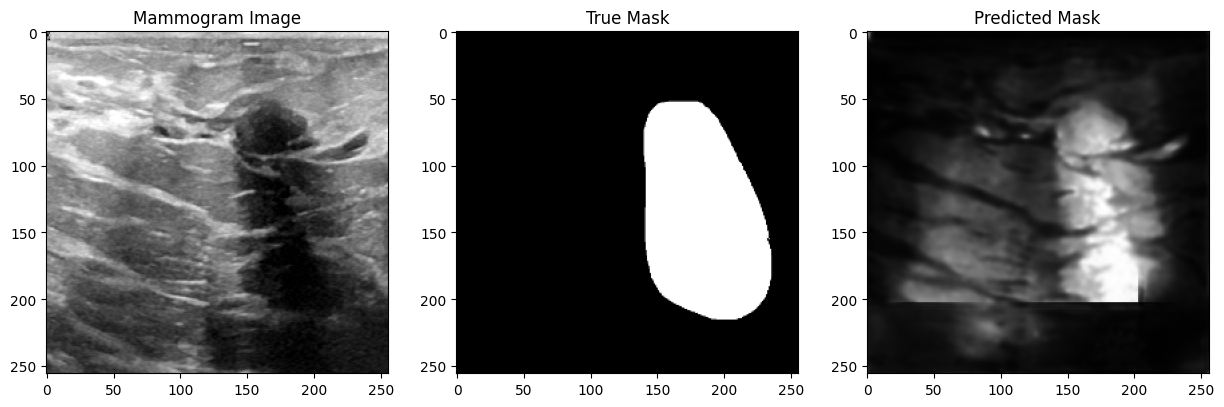

1/1 [==============================] - 0s 21ms/step


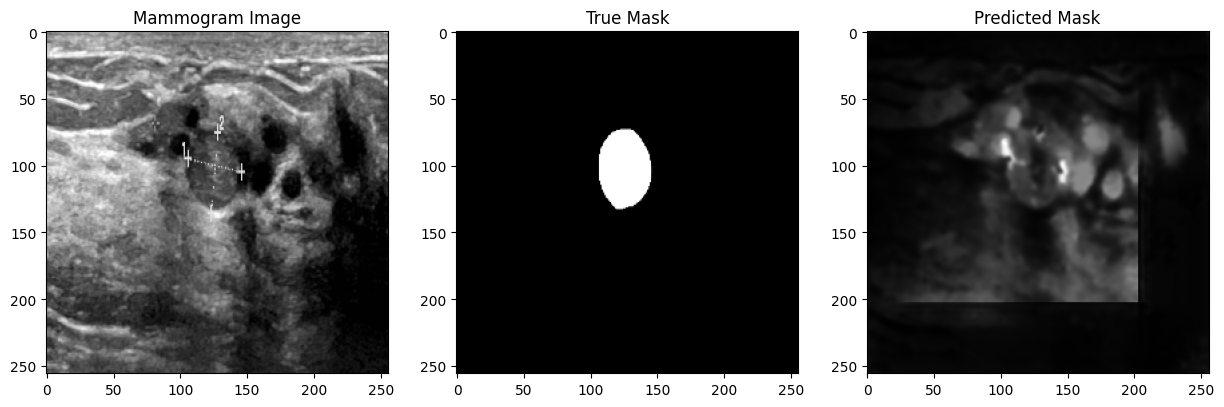

1/1 [==============================] - 0s 21ms/step


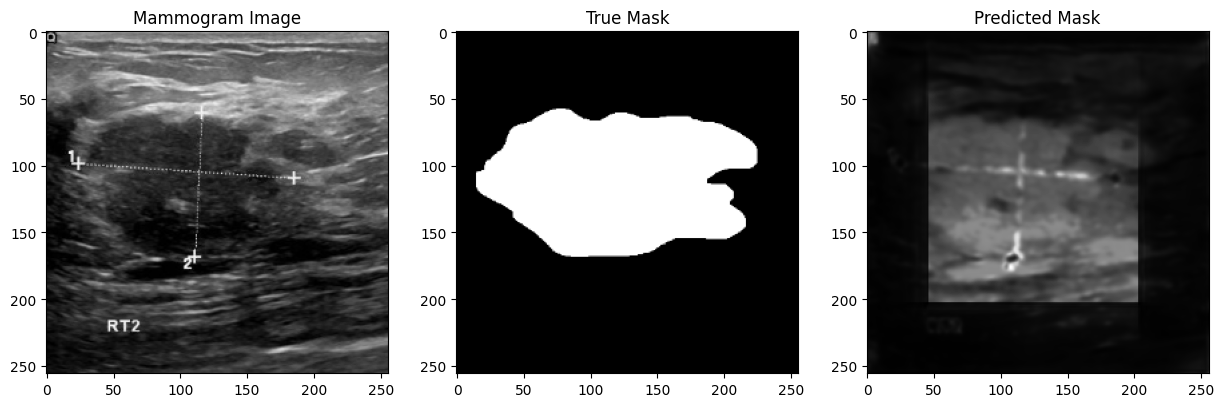

1/1 [==============================] - 0s 23ms/step


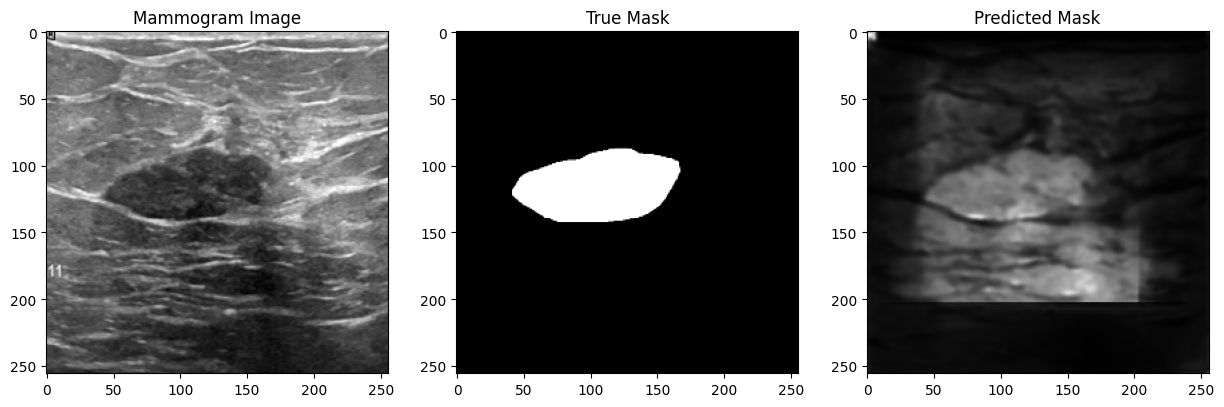

1/1 [==============================] - 0s 22ms/step


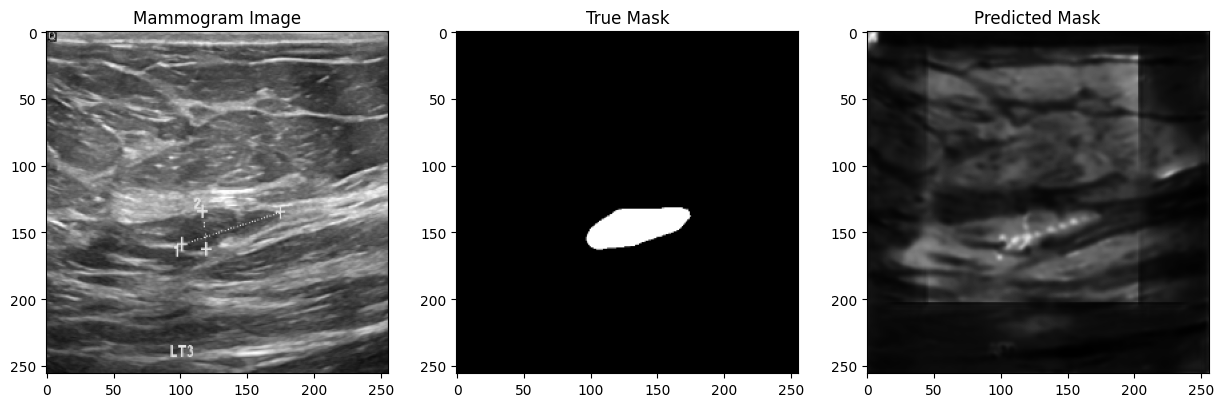

In [18]:
# Visualize predictions on validation set
visualize_predictions(model, X_val, y_val, num_samples=5)

In [19]:

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

5/5 [==============================] - 1s 128ms/step - loss: 0.2102 - accuracy: 0.9272
Validation Loss: 0.21024009585380554
Validation Accuracy: 0.9272472858428955


In [ ]:
# Save the model
model.save('unet_model.h5')

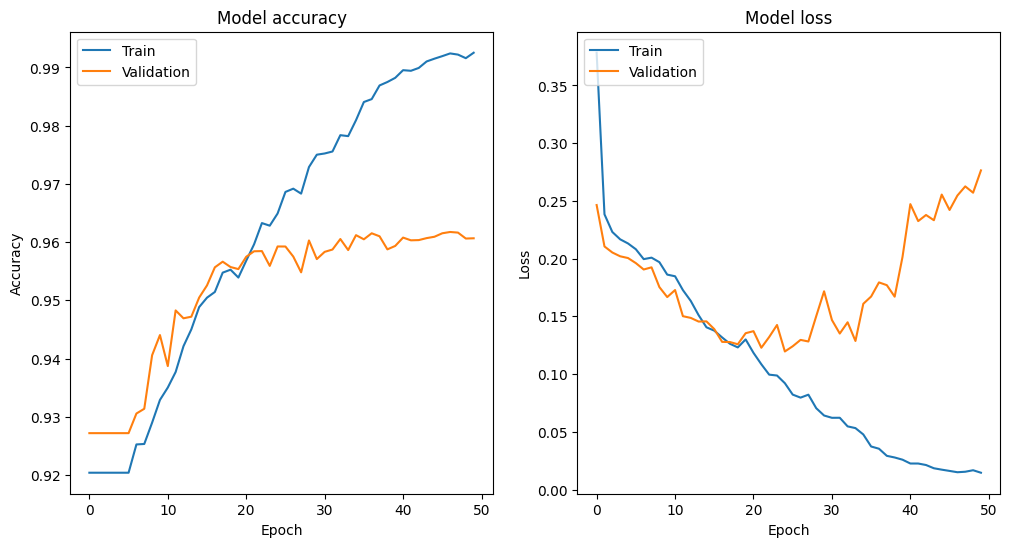

In [ ]:
# # Plot training & validation accuracy values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# plt.show()

In [ ]:
# Visualize some predictions
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = np.random.randint(0, len(X))

    has_mask = y[ix].max() > 0  # Check if any mask is present in the ground truth

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[0].set_title('Original')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Ground Truth')

    ax[2].imshow(preds[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[2].set_title('Prediction')

    ax[3].imshow(binary_preds[ix].squeeze(), cmap='gray')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[3].set_title('Binary Prediction')

    plt.show()

5/5 [==============================] - 26s 3s/step


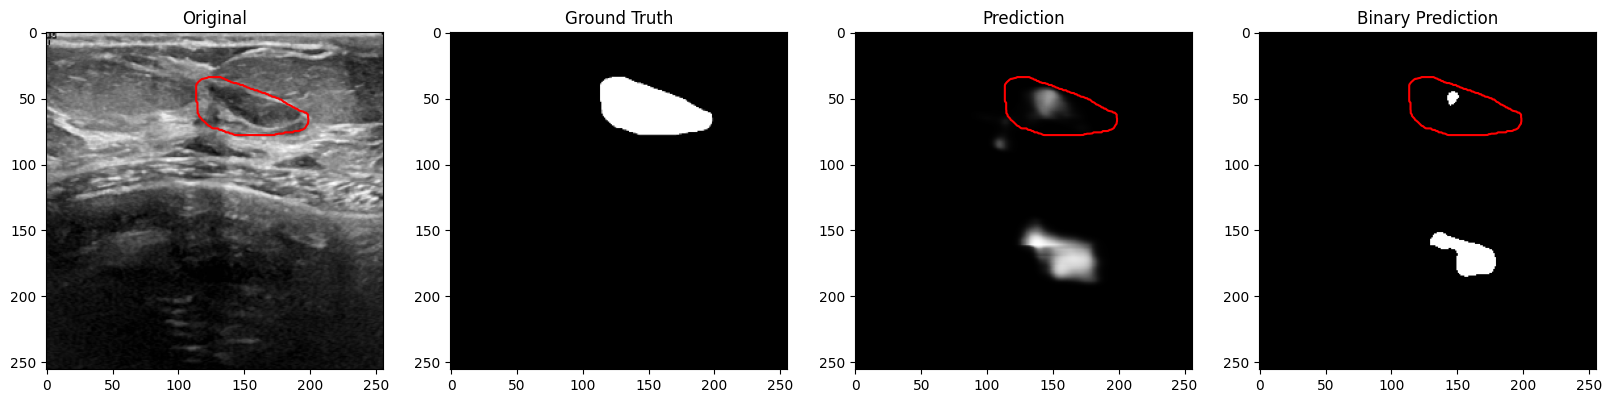

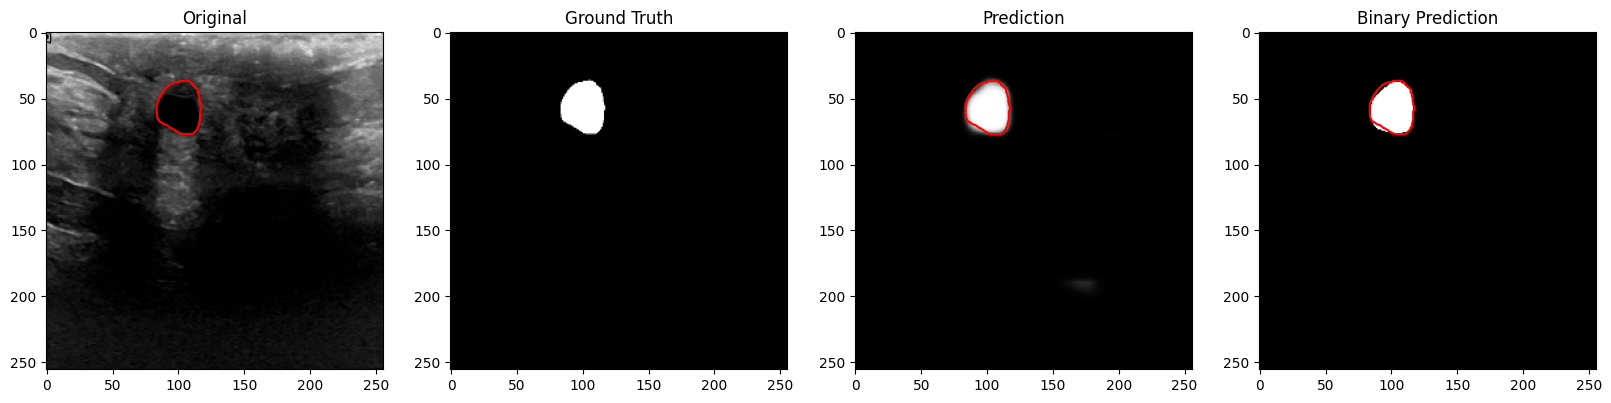

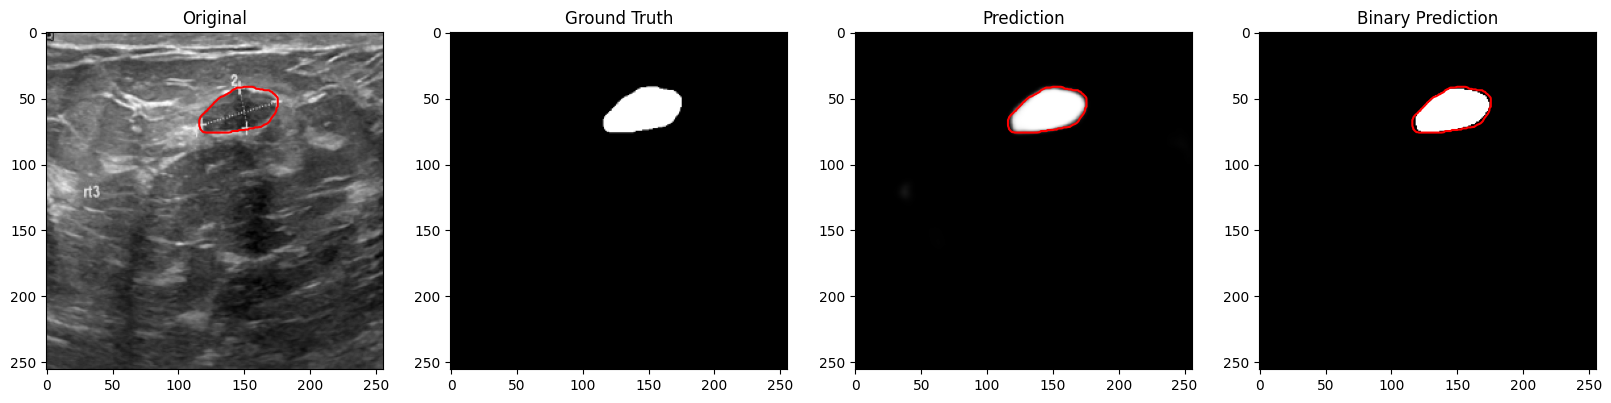

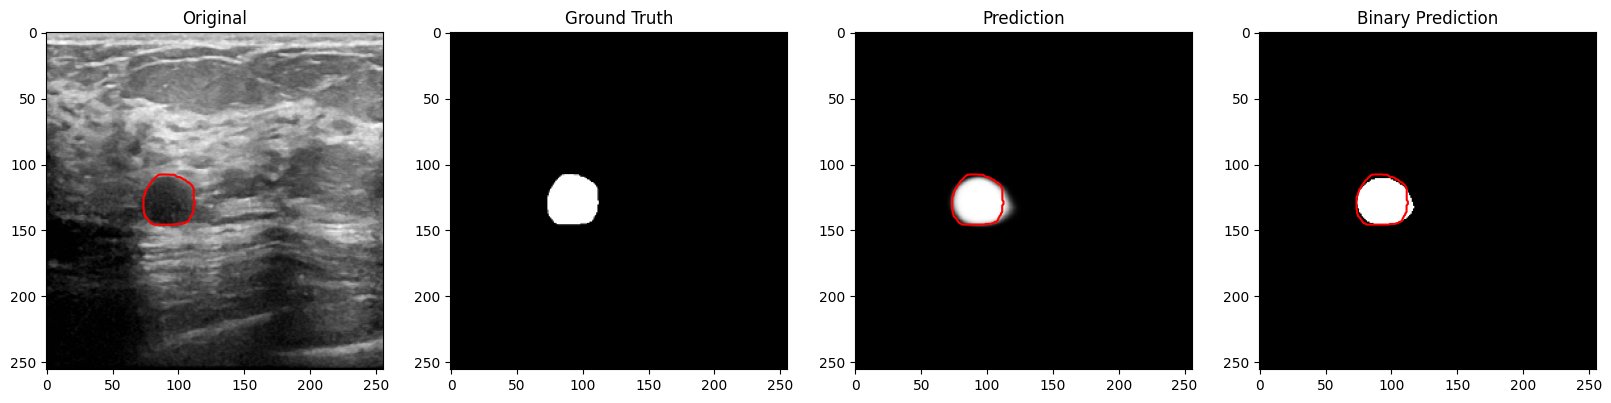

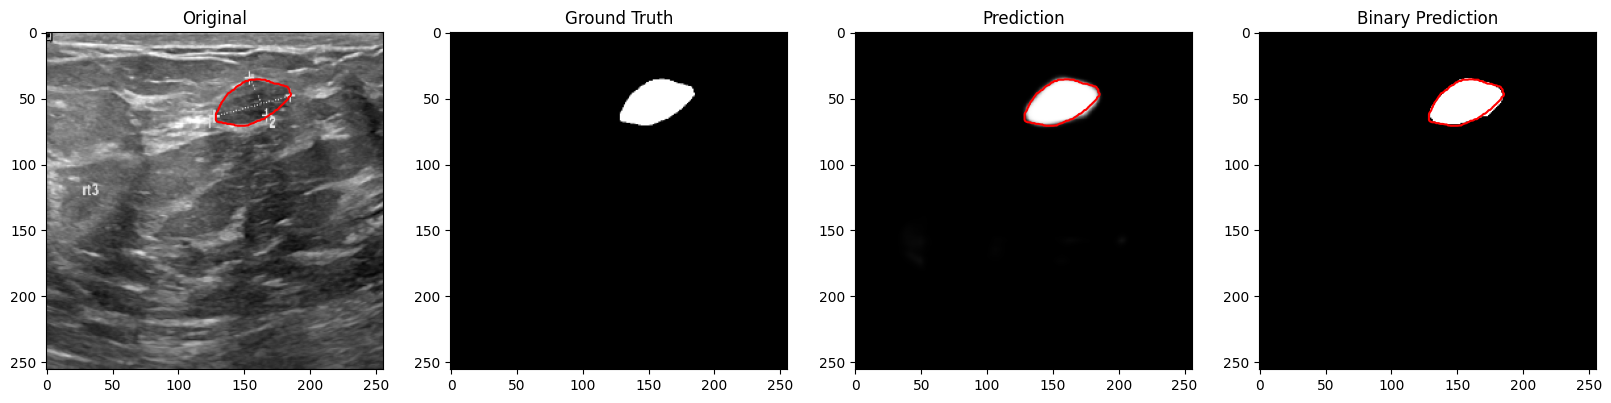

In [ ]:
# Predict on the validation set and visualize results
preds_val = model.predict(X_val, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Plot some examples
for i in range(5):
    plot_sample(X_val, y_val, preds_val, preds_val_t)